# PERMBU

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism-Permbu-Intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies and also allows you to calculate prediction intervals for all hierarchies. In this notebook we will see how to do it.

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# compute base forecast no coherent
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation

/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160464
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.448533


The dataset can be grouped in the following strictly hierarchical structure.

In [ ]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'State', 'Region']
]

Using the `aggregate` function from `HierarchicalForecast` we can get the full set of time series.

In [ ]:
Y_df, S_df, tags = aggregate(df=Y_df, spec=spec)
Y_df = Y_df.reset_index()

/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
Y_df.head()

,unique_id,ds,y
0,Australia,1998-01-01,23182.197269
1,Australia,1998-04-01,20323.380067
2,Australia,1998-07-01,19826.640511
3,Australia,1998-10-01,20830.129891
4,Australia,1999-01-01,22087.353380


In [ ]:
S_df.iloc[:5, :5]

,Australia/ACT/Canberra,Australia/New South Wales/Blue Mountains,Australia/New South Wales/Capital Country,Australia/New South Wales/Central Coast,Australia/New South Wales/Central NSW
Australia,1.0,1.0,1.0,1.0,1.0
Australia/ACT,1.0,0.0,0.0,0.0,0.0
Australia/New South Wales,0.0,1.0,1.0,1.0,1.0
Australia/Northern Territory,0.0,0.0,0.0,0.0,0.0
Australia/Queensland,0.0,0.0,0.0,0.0,0.0


In [ ]:
tags['Country/State']

array(['Australia/ACT', 'Australia/New South Wales',
       'Australia/Northern Territory', 'Australia/Queensland',
       'Australia/South Australia', 'Australia/Tasmania',
       'Australia/Victoria', 'Australia/Western Australia'], dtype=object)

We can visualize the `S` matrix and the data using the `HierarchicalPlot` class as follows.

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)

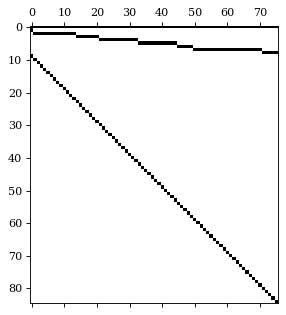

In [ ]:
hplot.plot_summing_matrix()

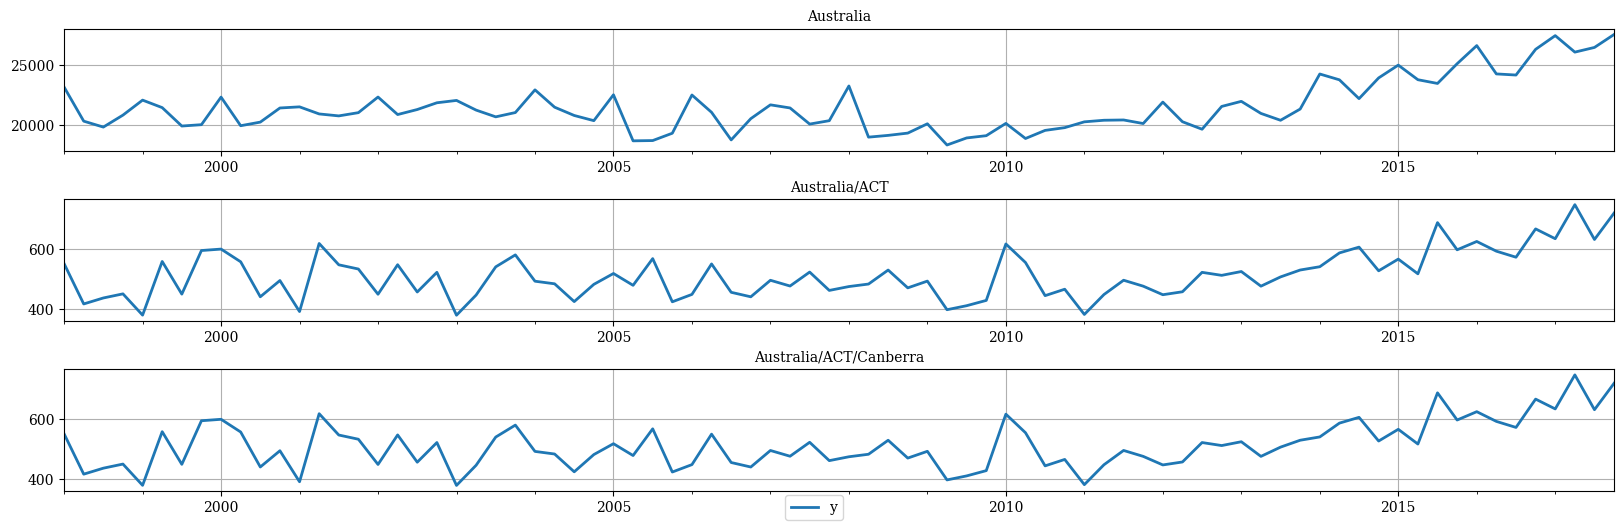

In [ ]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra',
    Y_df=Y_df.set_index('unique_id')
)

### Split Train/Test sets

We use the final two years (8 quarters) as test set.

In [ ]:
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

In [ ]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [ ]:
Y_train_df.groupby('unique_id').size()

unique_id
Australia                                                 72
Australia/ACT                                             72
Australia/ACT/Canberra                                    72
Australia/New South Wales                                 72
Australia/New South Wales/Blue Mountains                  72
                                                          ..
Australia/Western Australia/Australia's Coral Coast       72
Australia/Western Australia/Australia's Golden Outback    72
Australia/Western Australia/Australia's North West        72
Australia/Western Australia/Australia's South West        72
Australia/Western Australia/Experience Perth              72
Length: 85, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `AutoARIMA` and model. Observe that `Y_hat_df` contains the forecasts but they are not coherent. To reconcile the prediction intervals we need to calculate the uncoherent intervals using the `level` argument of `StatsForecast`.

In [ ]:
fcst = StatsForecast(df=Y_train_df,
                     models=[AutoARIMA(season_length=4)], 
                     freq='QS', n_jobs=-1)
Y_hat_df = fcst.forecast(h=8, fitted=True, level=[80, 90])
Y_fitted_df = fcst.forecast_fitted_values()

## Reconcile forecasts and compute prediction intervals using PERMBU

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. In this example we use `BottomUp` and `MinTrace`. If you want to calculate prediction intervals, you have to use the `level` argument as follows and also `intervals_method='permbu'`.

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df,
                          S=S_df, tags=tags,
                          level=[80, 90], intervals_method='permbu')

/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/cchallu/opt/anaconda3/envs/hierarchicalforecast/lib

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [ ]:
Y_rec_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90,AutoARIMA/BottomUp,AutoARIMA/BottomUp-lo-90,AutoARIMA/BottomUp-lo-80,AutoARIMA/BottomUp-hi-80,...,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/MinTrace_method-mint_shrink-lo-90,AutoARIMA/MinTrace_method-mint_shrink-lo-80,AutoARIMA/MinTrace_method-mint_shrink-hi-80,AutoARIMA/MinTrace_method-mint_shrink-hi-90,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-ols-lo-90,AutoARIMA/MinTrace_method-ols-lo-80,AutoARIMA/MinTrace_method-ols-hi-80,AutoARIMA/MinTrace_method-ols-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
Australia,2016-01-01,26212.554688,24694.224609,25029.580078,27395.527344,27730.884766,24864.632812,24132.690934,24303.710380,25415.306579,...,25394.674193,24688.184716,24829.128625,25915.019578,26126.996743,26133.747296,25448.142013,25610.978983,26680.508765,26911.313461
Australia,2016-04-01,25033.667969,23324.066406,23701.669922,26365.666016,26743.269531,23276.046875,22616.403356,22734.157837,23966.769005,...,24005.168866,23423.020450,23545.015525,24624.275946,24707.026860,24934.545113,24299.364023,24480.624626,25525.242528,25667.067630
Australia,2016-07-01,24507.027344,22625.500000,23041.076172,25972.978516,26388.554688,22652.144531,21930.239691,22156.110097,23212.345935,...,23342.645071,22554.139998,22800.905452,23896.489967,24019.251797,24373.964019,23539.587500,23799.296237,24995.273284,25122.593581
Australia,2016-10-01,25598.929688,23559.919922,24010.281250,27187.578125,27637.937500,23343.187500,22561.109015,22757.435875,23901.833744,...,24284.274936,23614.246672,23751.013776,24756.696874,24884.792590,25478.075727,24737.784789,24851.673658,26028.746607,26239.433127
Australia,2017-01-01,26982.578125,24651.535156,25166.396484,28798.757812,29313.619141,24531.230469,23701.777099,23865.969022,25149.462890,...,25507.915580,24631.409330,24813.639146,26176.373109,26286.636241,26842.902809,25919.476475,26164.820989,27547.180948,27750.384070


## Plot forecasts

Then we can plot the probabilist forecasts using the following function.

In [ ]:
plot_df = pd.concat([Y_df.set_index(['unique_id', 'ds']), 
                     Y_rec_df.set_index('ds', append=True)], axis=1)
plot_df = plot_df.reset_index('ds')

### Plot single time series

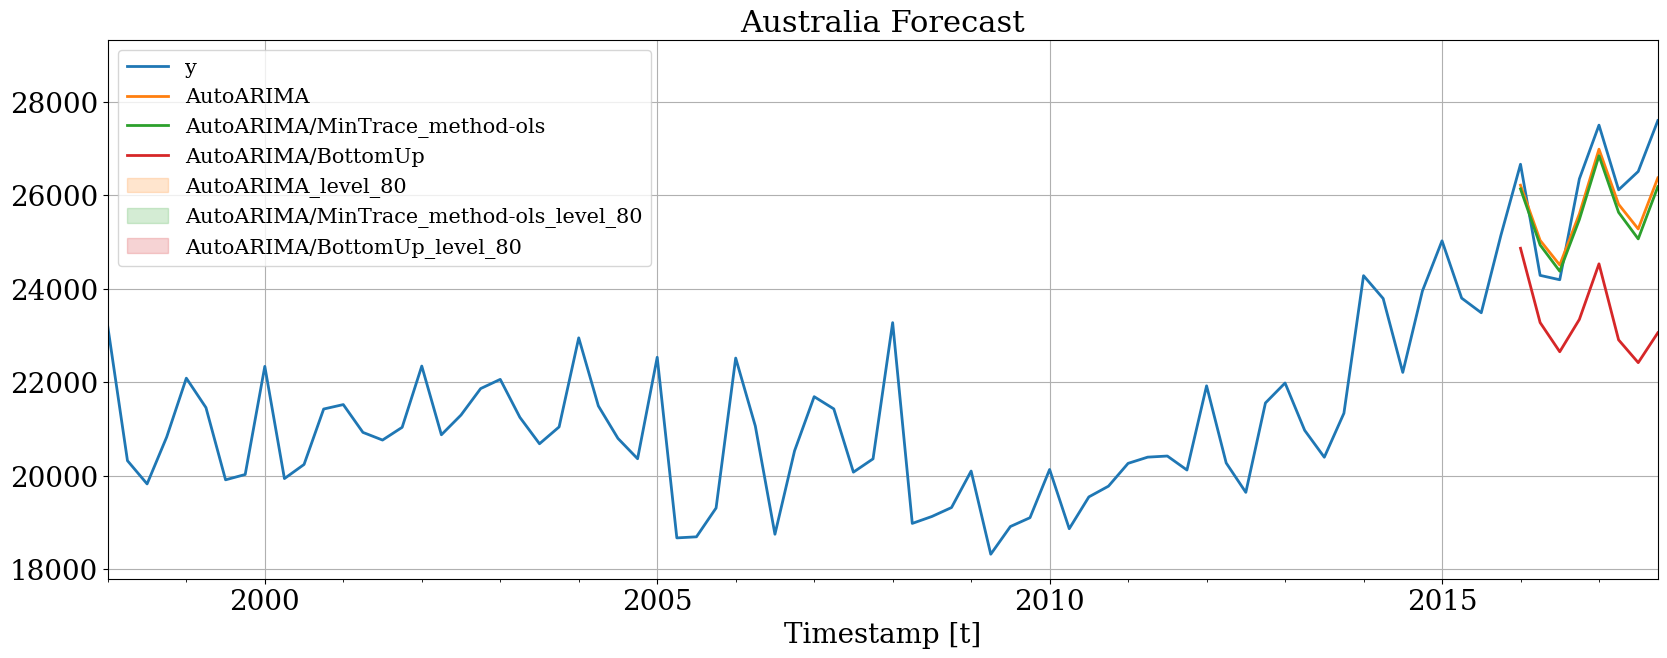

In [ ]:
hplot.plot_series(
    series='Australia',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 
            'AutoARIMA/MinTrace_method-ols',
            'AutoARIMA/BottomUp'
           ],
    level=[80]
)

### Plot hierarchichally linked time series

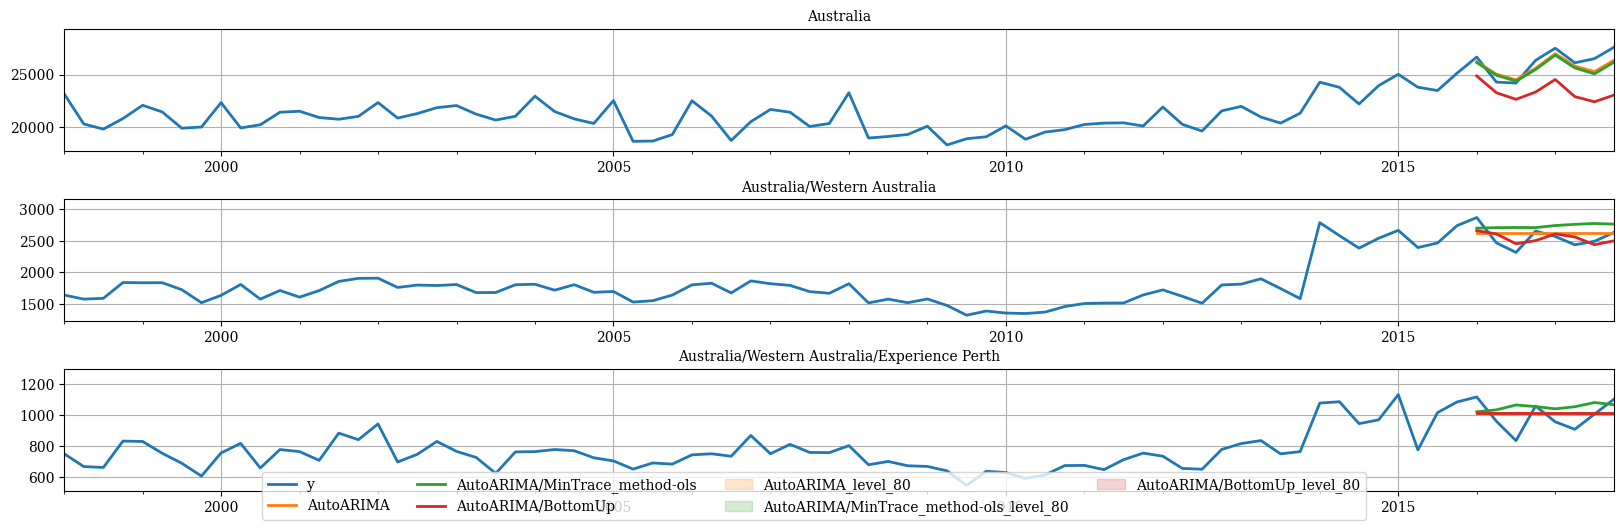

In [ ]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols', 'AutoARIMA/BottomUp'],
    level=[80]
)

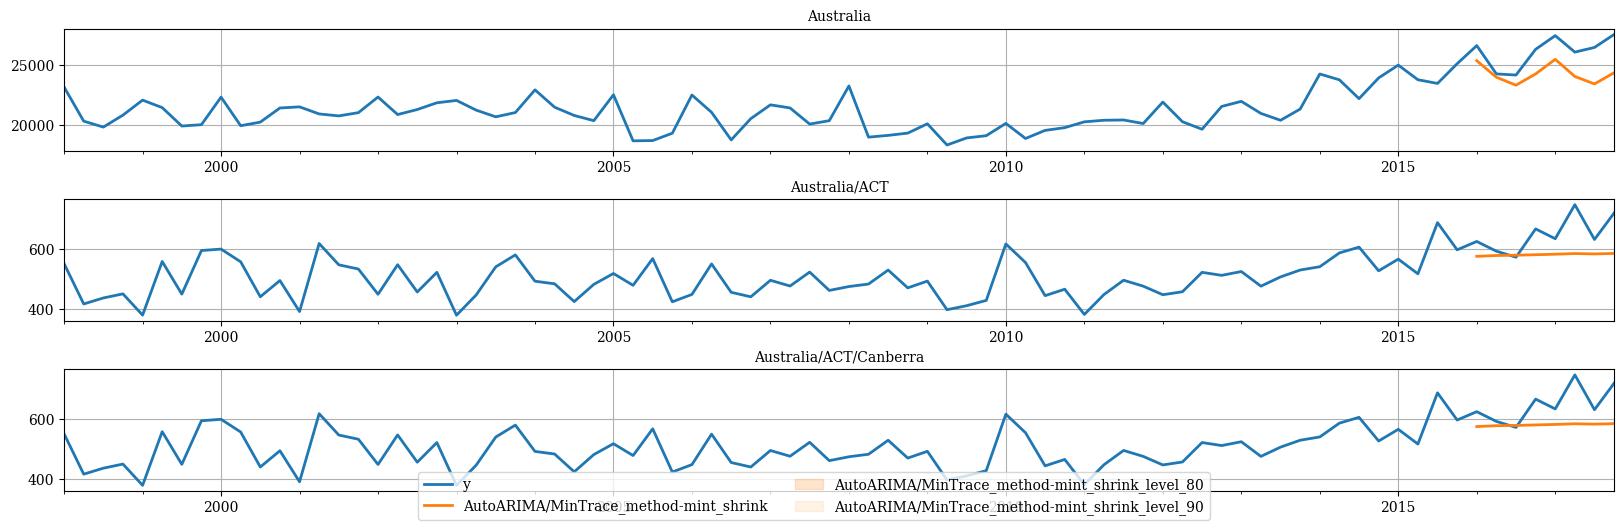

In [ ]:
# ACT only has Canberra
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA/MinTrace_method-mint_shrink'],
    level=[80, 90]
)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Shanika L. Wickramasuriya, George Athanasopoulos, and Rob J. Hyndman. Optimal forecast reconciliation for hierarchical and grouped time series through trace minimization.Journal of the American Statistical Association, 114(526):804–819, 2019. doi: 10.1080/01621459.2018.1448825. URL https://robjhyndman.com/publications/mint/.](https://robjhyndman.com/publications/mint/)